In [2]:
%run "! DEFAULT PLOT THINGIES.ipynb"
%run "../! DEFAULT PLOT THINGIES.ipynb"

<IPython.core.display.Javascript object>

`%matplotlib` prevents importing * from pylab and numpy


Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\biax-ACF-ACT
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\biax-ACF-ACT
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
### FROM http://stackoverflow.com/a/6520696/118671

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def fixup_nans(y):
    nans, x = nan_helper(y)
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return y

In [4]:
# first, we need to fit all measurements. Again, just to make sure we're doing the right thing.
from scipy.optimize import curve_fit

def fitfn(dt, A, beta, C):
    return A*(dt**beta) + C

p0 = (0.1, 1.7, 1)


def load_measurement(path):
    if os.path.exists(path + '/metingen.npz'):
        return np.load(path + "/metingen.npz")['variances'][1:]  # dt, var
    
    elif os.path.exists(path + "/dt00001.txt"):
        # load all txt files. These are # frame spaced not time
        data = [np.loadtxt(path + "/dt%05i.txt" % i) for i in range(1,21)]
        kortste = min([len(x) for x in data])
        return np.vstack([x[:kortste] for x in data])
        
    else:
        raise Exception("Data not found... %s" % path)
        
for measurement in all_biax_measurements:
    errors = 0
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    if not os.path.exists(vardtpath):
        outputfn = vardtpath + "/biax-ACF-ACT-fit.npy"
        if os.path.exists(outputfn):
            pass #continue
        print name, measurement['phi']

        var_vs_dts = load_measurement(vardtpath)
        
        max_index = int(20 * measurement['frame_rate'])
        var_vs_dts = var_vs_dts[:max_index]
        
        dt = np.arange(1,len(var_vs_dts)+1) / measurement['frame_rate']
        
        fitdata = []
        for t in np.arange(var_vs_dts.shape[1]):
            try:
                parm, cov = curve_fit(fitfn, dt, var_vs_dts[:,t], p0)
                fitdata.append(parm)
            except Exception as e:
                fitdata.append([np.nan] * len(p0))
                errors += 1
                
        print "%i failures in fitting, len %i" % (errors, len(fitdata))

        np.save(outputfn, fitdata)        

In [5]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    #assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [7]:
#np.sum(np.isnan(fitdata[:,0]))  # MOETEN NOG GEHANDLED> KUDT

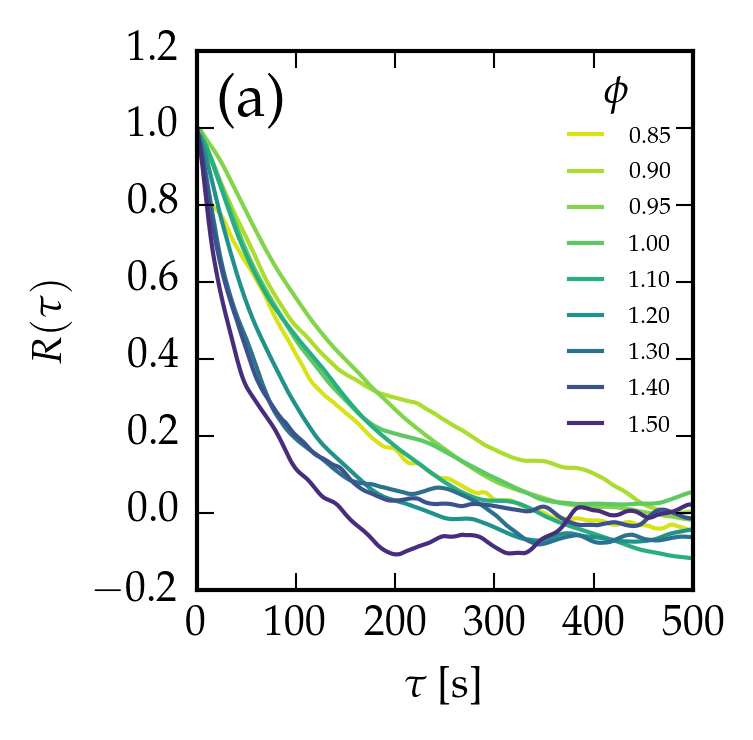

In [8]:
# plot autocorrelatiefunctie
# voor tau = max 20 s? oid
# voor een aantal phis
f1 = halffig()
ax1 = f1.gca()


cmap = get_cmap('viridis_r')
phi_norm = mpl.colors.Normalize(vmin=0.8, vmax=1.6)

for measurement in sorted(all_biax_measurements, key=lambda x: x['phi']):
    if '20150907' not in measurement['path']:
        continue
    
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    fitfn = vardtpath + "/biax-ACF-ACT-fit.npy"  
    
    fitdata = np.load(fitfn)
    
    fitdata[:,0] = fixup_nans(fitdata[:,0])
    fitdata[:,1] = fixup_nans(fitdata[:,1])
    acf = estimated_autocorrelation(np.log10(fitdata[:,0]* 10**fitdata[:,1]))

    t = np.arange(500) / measurement['frame_rate']
    phi = measurement['phi']
    ax1.plot(t, acf[:500], color=cmap(phi_norm(phi)), label="%0.2f" % phi)

ax1.legend(loc='upper right', fontsize='xx-small', frameon=False, title=r"$\phi$")
ax1.set_ylabel(r"$R(\tau)$")
ax1.set_xlabel(r"$\tau$ [s]")

subplotlabel('(a)', ax=ax1)

f1.savefig('R-tau.pdf')

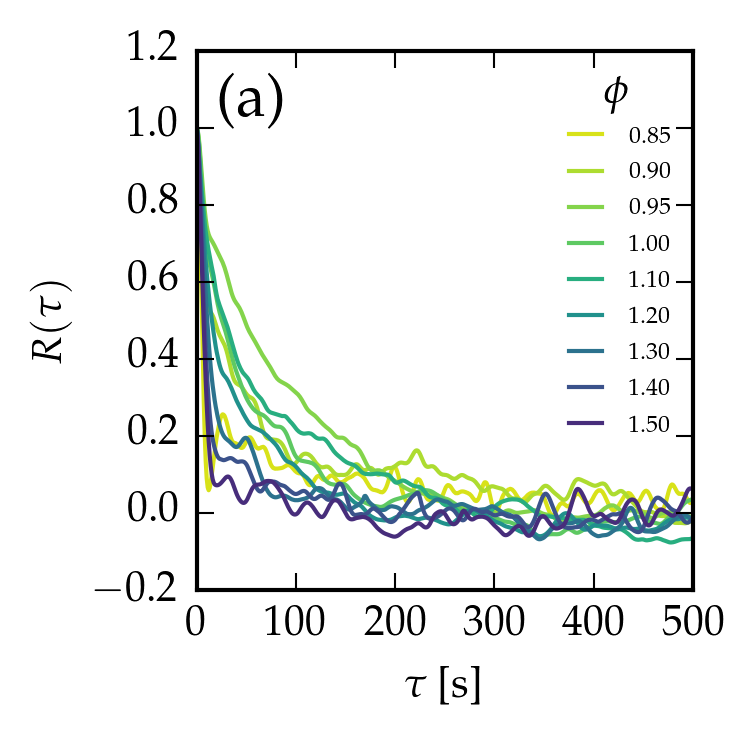

In [18]:
# plot autocorrelatiefunctie
# voor tau = max 20 s? oid
# voor een aantal phis
f1 = halffig()
ax1 = f1.gca()


cmap = get_cmap('viridis_r')
phi_norm = mpl.colors.Normalize(vmin=0.8, vmax=1.6)

for measurement in sorted(all_biax_measurements, key=lambda x: x['phi']):
    if '20150907' not in measurement['path']:
        continue
    
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    fitfn = vardtpath + "/biax-ACF-ACT-fit.npy"  
    
    fitdata = np.load(fitfn)
    
    fitdata[:,0] = fixup_nans(fitdata[:,0])
    fitdata[:,1] = fixup_nans(fitdata[:,1])
    acf = estimated_autocorrelation(np.log10(fitdata[:,0]) - fitdata[:,1])

    t = np.arange(500) / measurement['frame_rate']
    phi = measurement['phi']
    ax1.plot(t, acf[:500], color=cmap(phi_norm(phi)), label="%0.2f" % phi)

ax1.legend(loc='upper right', fontsize='xx-small', frameon=False, title=r"$\phi$")
ax1.set_ylabel(r"$R(\tau)$")
ax1.set_xlabel(r"$\tau$ [s]")

subplotlabel('(a)', ax=ax1)

f1.savefig('R-tau-alt.pdf')

In [12]:
from scipy.optimize import curve_fit

import collections
setjes = collections.defaultdict(list)

for measurement in sorted(all_biax_measurements, key=lambda x: x['phi']):
    if np.round(log10(measurement['shear_rate']), 2) != -4.52:
        continue
    
    date = os.path.split(measurement['path'].split(" ")[0])[1]
    
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    fitfn = vardtpath + "/biax-ACF-ACT-fit.npy"  
    
    try:
        fitdata = np.load(fitfn)
    except IOError as e:
        #print e
        continue
    nnans = np.sum(np.isnan(fitdata[:,0]))
    
    msk = (fitdata[:,0] < 0)
    fitdata[:,0][msk] = np.nan
    fitdata[:,1][msk] = np.nan
    
    if nnans > 0:
        #print 'Fixing up %i nans by interpolating' % nnans, measurement['path']
        fitdata[:,0] = fixup_nans(fitdata[:,0])
        fitdata[:,1] = fixup_nans(fitdata[:,1])
        
    acf = estimated_autocorrelation(np.log10(fitdata[:,0]* 10**fitdata[:,1]))

    t = np.arange(500) / measurement['frame_rate']
    
    def fitfn(tau, tau0, taustar):
        return np.exp(-(tau-tau0)/taustar)
    
    mask = acf[:500] > 0.5
    p, cov = curve_fit(fitfn, t[mask], acf[:500][mask], p0=(1, 50,))
    
    setjes[date].append([measurement, p, cov])

20160106 x c
20160126 + m
20150821 ^ y
20150907 v r
20160202 < g
20160219 > b
20150909 s k
\includegraphics{notebooks/biax-ACF-ACT/taustar-3e-5.pdf}


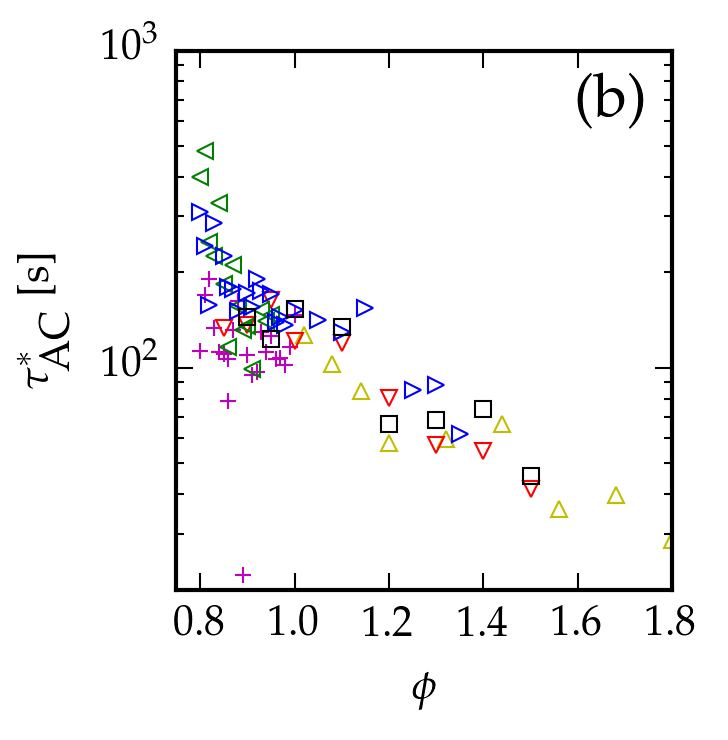

In [13]:
halffig()
subplotlabel('(b)', loc='upper right')

i = 0
markers = "x+^v<>s"
colors = "cmyrgbk"

for setje, data in setjes.iteritems():
    if len(data) < 3:
        continue
        
    if setje < '2015':
        color = 'gray'
        marker = '.'
        continue
    else:
        color = colors[i]
        marker = markers[i]
        i += 1
    print setje, marker, color
        
    data = sorted(data, key=lambda x: x[0]['phi'])
    phis = [x[0]['phi'] for x in data]
    if np.amax(phis) < 0.9:
        continue
    taustars = [x[1][1] for x in data]
    
    plt.plot(phis, taustars,
             linestyle='none',
             mfc='none',
             color=color,
             mec=color,
             marker=marker,
             lw=0.5, ms=4)
    


plt.semilogy()
plt.axis(xmin=0.75, ymin=20)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\tau^*_\textrm{AC}$ [s]")
plt.savefig('taustar-3e-5.pdf')

In [46]:
#0.87 set([0.0003, 1e-05, 0.0001, 3e-05])
#1.0 set([0.0003, 0.001, 0.0001, 0.003, 3e-05, 0.01])
#1.5 set([0.0003, 0.001, 0.0001, 0.003, 3e-05, 0.01])


phis = collections.defaultdict(set)

for m in sorted(all_biax_measurements, key=lambda x: x['phi']):
    if '2013' in m['path']: # < 2015:
        continue
    phis[np.round(m['phi'],2)].update([m['shear_rate']])
    

for p,d in sorted(phis.iteritems(), key=lambda x: len(x[1])):
    print p,d

0.75 set([0.0003])
1.25 set([3e-05])
1.35 set([3e-05])
1.44 set([3e-05])
1.02 set([3e-05])
0.7 set([0.0003])
1.68 set([3e-05])
1.13 set([0.0003])
1.15 set([3e-05])
0.77 set([0.0003])
1.32 set([3e-05])
0.71 set([0.0003])
1.22 set([0.0003])
0.78 set([0.0003])
0.97 set([3e-05])
1.8 set([3e-05])
0.79 set([1e-05])
0.73 set([0.0003])
1.14 set([3e-05])
1.37 set([0.0001])
1.08 set([3e-05])
0.99 set([3e-05])
1.56 set([3e-05])
1.04 set([0.0003])
1.29 set([1e-05])
0.94 set([0.0003, 3e-05])
0.98 set([0.0001, 3e-05])
0.82 set([0.0003, 3e-05])
0.96 set([0.0003, 3e-05])
0.91 set([0.0003, 3e-05])
0.8 set([0.0003, 3e-05])
0.93 set([0.0003, 3e-05])
0.81 set([0.0003, 3e-05])
0.88 set([0.0003, 0.0001, 3e-05])
0.95 set([0.0003, 0.0001, 3e-05])
0.83 set([0.0003, 1e-05, 3e-05])
0.9 set([0.0003, 0.0001, 3e-05])
0.84 set([0.0003, 0.0001, 3e-05])
0.85 set([0.0003, 0.0001, 3e-05])
0.86 set([0.0003, 0.0001, 3e-05])
1.05 set([1e-05, 0.0001, 3e-05])
0.89 set([0.0003, 1e-05, 0.0001, 3e-05])
0.92 set([0.0003, 1e-05, 

In [47]:
import collections
setjes = collections.defaultdict(list)

for measurement in sorted(all_biax_measurements, key=lambda x: x['phi']):
    phi = np.round(measurement['phi'],2)
    
    if phi not in [0.87, 1.0, 1.5] or '2013' in measurement['path']:
        continue
    
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    fitfn = vardtpath + "/biax-ACF-ACT-fit.npy"  
    
    try:
        fitdata = np.load(fitfn)
    except IOError as e:
        print e
        continue

    
    msk = (fitdata[:,0] < 0)
    fitdata[:,0][msk] = np.nan
    fitdata[:,1][msk] = np.nan
    
    nnans = np.sum(np.isnan(fitdata[:,0]))
    if nnans > 0:
        #print 'Fixing up %i nans by interpolating' % nnans, measurement['path']
        fitdata[:,0] = fixup_nans(fitdata[:,0])
        fitdata[:,1] = fixup_nans(fitdata[:,1])

    acf = estimated_autocorrelation(np.log10(fitdata[:,0]* 10**fitdata[:,1]))

    t = np.arange(500) / measurement['frame_rate']
    
    def fitfn(tau, tau0, taustar):
        return np.exp(-(tau-tau0)/taustar)
    
    mask = acf[:500] > 0.5
    p, cov = curve_fit(fitfn, t[mask], acf[:500][mask], p0=(1, 50,))
    
    setjes[phi].append([measurement, p, cov])

Fixing up 195 nans by interpolating u:/20160218 helderdere verlichting quick step 3e-5\20160218T223731~gdot3.00000E-4~A426052000000.00000
Fixing up 2 nans by interpolating u:/20160202 nogmaals rond phij\20160203T154851~gdot3.00000E-5~A489714942528.73560
[Errno 2] No such file or directory: u'u:/20160209 rond phij high gammadot\\vardt\\20160209T170331~gdot3.00000E-4~A489714942528.73560/biax-ACF-ACT-fit.npy'
Fixing up 15 nans by interpolating u:/20160106 rond phij 2\20160108T181300~gdot3.00000E-5~A520000000000.00000
Fixing up 3 nans by interpolating u:/20160219 heldere verlichting grote phiset\20160221T185451~gdot3.00000E-5~A425839080459.77008
Fixing up 156 nans by interpolating U:/20150804 shear 1e-4 diffphi\20150804T211939~gdot1.00000E-4~A485000000000.00000
Fixing up 17 nans by interpolating U:/20150813 1e-5\20150815T115819~gdot1.00000E-5~A524000000000.00000
Fixing up 170 nans by interpolating u:/20150901 high phi diff gdot\20150901T161226~gdot3.00000E-4~A555000000000.00000
Fixing up 1

\includegraphics{notebooks/biax-ACF-ACT/taustar-vs-gammadot.pdf}


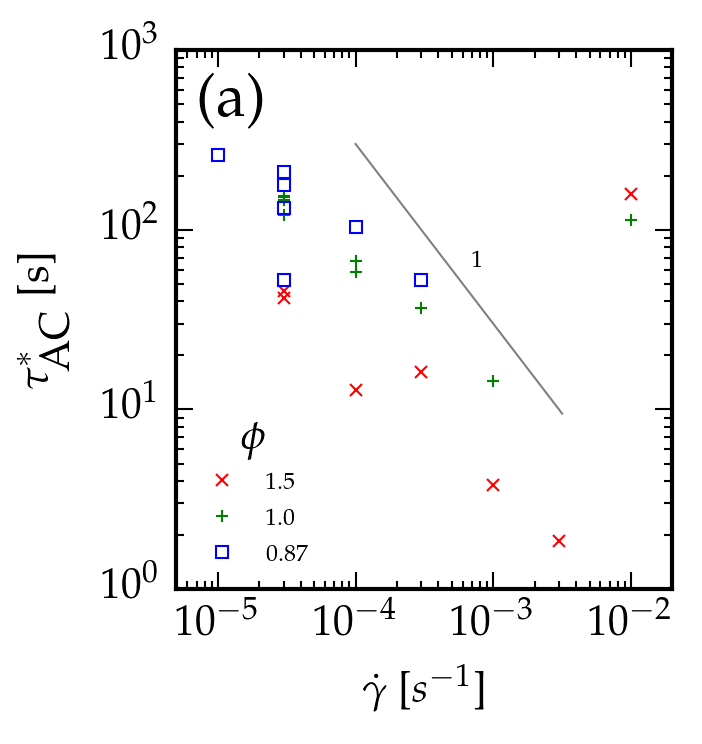

In [48]:
halffig()
subplotlabel('(a)')

i = 0
markers = "x+s"
colors = "rgbk"

elems = []

for setje, data in setjes.iteritems():
    data = sorted(data, key=lambda x: x[0]['shear_rate'])
    gammadots = [x[0]['shear_rate'] for x in data]

    taustars = [x[1][1] for x in data]
  
    marker = markers[i]
    color = colors[i]
    i += 1
    plt.plot(gammadots, taustars,
             marker, ms=3, label=str(setje),
             mec=color, color=color, mfc='none')
    for x,y in zip(gammadots, taustars):
        elems.append((x,y))

plt.axis(ymin=1e0, ymax=1e3)
plt.loglog()

x = np.logspace(-4,-2.5)
plt.plot(x, 3e-2/x, color='gray', lw=0.5)
plt.text(7e-4, 5e-2/8e-4, "1", fontsize='xx-small')
plt.legend(fontsize='xx-small', frameon=False, title=r"$\phi$", numpoints=1, loc='lower left')
plt.ylabel(r"$\tau^*_\textrm{AC}$ [s]")
plt.xlabel(r"$\dot\gamma$ [$s^{-1}$]")
plt.axis(xmin=5e-6, xmax=2e-2)
plt.savefig('taustar-vs-gammadot.pdf')

In [24]:
import collections
setjes = []

for measurement in sorted(all_biax_measurements, key=lambda x: x['phi']):
    phi = np.round(measurement['phi'],2)
    
    if '2013' in measurement['path']:
        continue
    
    base, name = os.path.split(measurement['path'])
    vardtpath = os.path.join(base, 'vardt', name)
    fitfn = vardtpath + "/biax-ACF-ACT-fit.npy"  
    
    try:
        fitdata = np.load(fitfn)
    except IOError as e:
        #print e
        continue

    
    msk = (fitdata[:,0] < 0)
    fitdata[:,0][msk] = np.nan
    fitdata[:,1][msk] = np.nan
    
    nnans = np.sum(np.isnan(fitdata[:,0]))
    if nnans > 0:
        #print 'Fixing up %i nans by interpolating' % nnans, measurement['path']
        fitdata[:,0] = fixup_nans(fitdata[:,0])
        fitdata[:,1] = fixup_nans(fitdata[:,1])

    acf = estimated_autocorrelation(np.log10(fitdata[:,0]* 10**fitdata[:,1]))

    t = np.arange(500) / measurement['frame_rate']
    
    def fitfn(tau, tau0, taustar):
        return np.exp(-(tau-tau0)/taustar)
    
    mask = acf[:500] > 0.5
    p, cov = curve_fit(fitfn, t[mask], acf[:500][mask], p0=(1, 50,))
    
    setjes.append([measurement, p, cov])

\includegraphics{notebooks/biax-ACF-ACT/taustar-vs-gammadot-and-phi.pdf}


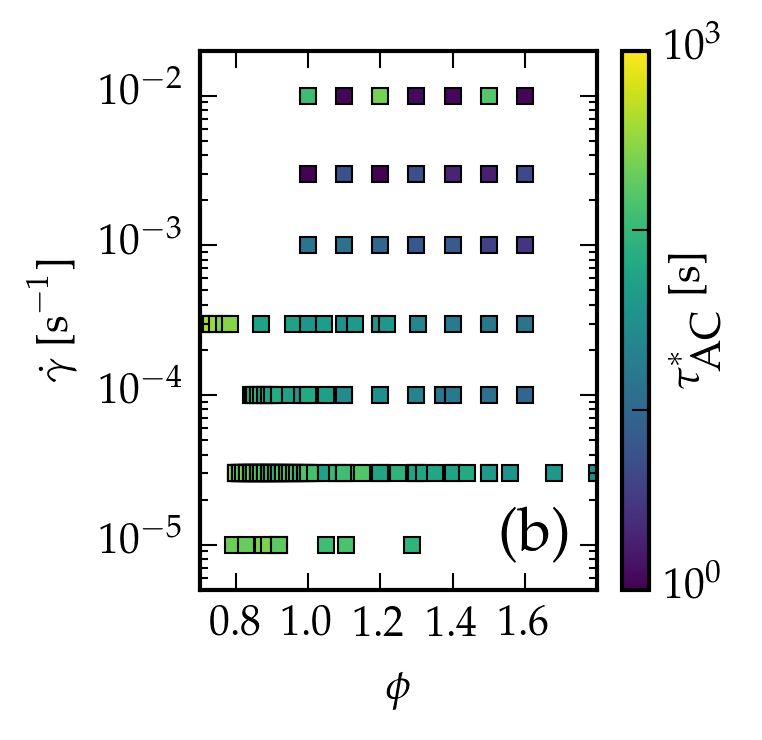

In [42]:
halffig()

cmap = get_cmap('viridis')
norm = mpl.colors.LogNorm(vmin=1e0, vmax=1e3)

for measurement, p, cov in setjes:
    plt.plot(measurement['phi'], measurement['shear_rate'], "s", color=cmap(norm(p[1])), ms=4)

plt.semilogy()
plt.ylabel(r"$\dot\gamma~\textrm{[s}^{-1}\textrm{]}$")
plt.xlabel(r"$\phi$")
plt.axis(xmin=0.7, xmax=1.8, ymin=5e-6, ymax=2e-2)

plt.xticks([0.8,1.0,1.2,1.4,1.6])
plt.scatter([-100], [-100], c=[1e-4], cmap=cmap, norm=norm)
cb = plt.colorbar()
cb.set_ticks([1e0,1e1,1e2,1e3])
cb.set_ticklabels(["$10^0$","","","$10^3$"])
cb.set_label(r'$\tau^*_\textrm{AC}~\textrm{[s]}$', labelpad=-10 )

subplotlabel('(b)', loc='lower right')

savefig('taustar-vs-gammadot-and-phi.pdf')